# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

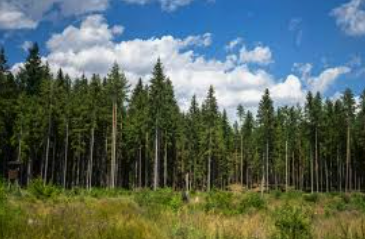

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({np.int32(3): 2747, np.int32(2): 2747, np.int32(6): 2747, np.int32(5): 2747, np.int32(4): 2747, np.int32(1): 2747, np.int32(0): 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [4]:
# Your code here

# 1. Stratified split
# Use train_test_split to create training and testing sets.
# The `stratify` argument ensures that the class proportions are the same in the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=random_seed
)

# 2. Standardize features
# Initialize the StandardScaler.
scaler = StandardScaler()

# Fit the scaler on the training data and transform it.
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler fitted on the training data.
X_test_scaled = scaler.transform(X_test)

### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



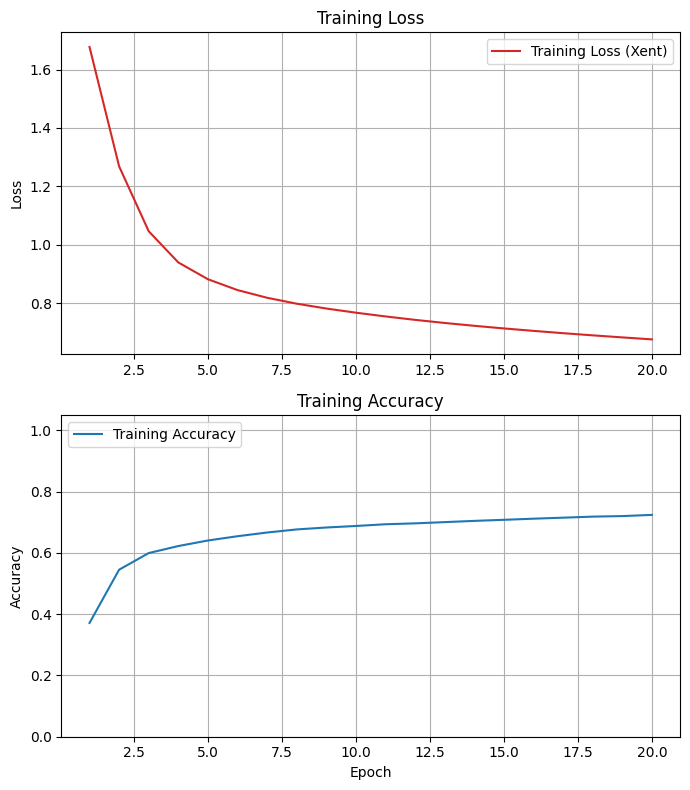

Final Training Loss:     0.6763
Final Training Accuracy: 0.7241


In [5]:
# Your code here

# 1. Build the model
# Define the sequential model architecture.
model_1 = Sequential([
    # Input layer with the shape of the features
    Input(shape=(X_train_scaled.shape[1],)),
    # First hidden layer with 64 neurons and ReLU activation
    Dense(64, activation='relu'),
    # Second hidden layer with 32 neurons and ReLU activation
    Dense(32, activation='relu'),
    # Output layer with 7 neurons (for 7 classes) and softmax activation
    Dense(7, activation='softmax')
])

# 2. Compile the model
# Compile the model with the specified optimizer, loss function, and metrics.
model_1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Train the model
# Fit the model to the training data for 20 epochs with a batch size of 32.
# The history object will store the training metrics.
history_1 = model_1.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    verbose=0  # Suppress output during training
)

# 4. Evaluate training
# Plot the training loss and accuracy curves.
plot_history(history_1)



In [6]:
# Set a1a to the final training accuracy at epoch 20

a1a = history_1.history['accuracy'][-1]             # Replace 0.0 with your answer

In [7]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.7241


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!

--- Training with Batch Size: 4 ---


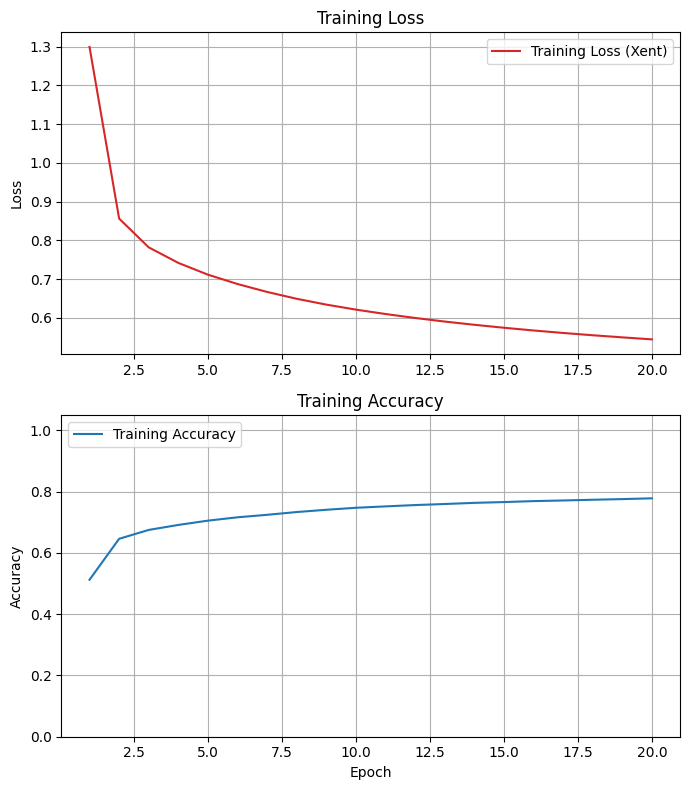

Final Training Loss:     0.5444
Final Training Accuracy: 0.7782
--- Training with Batch Size: 8 ---


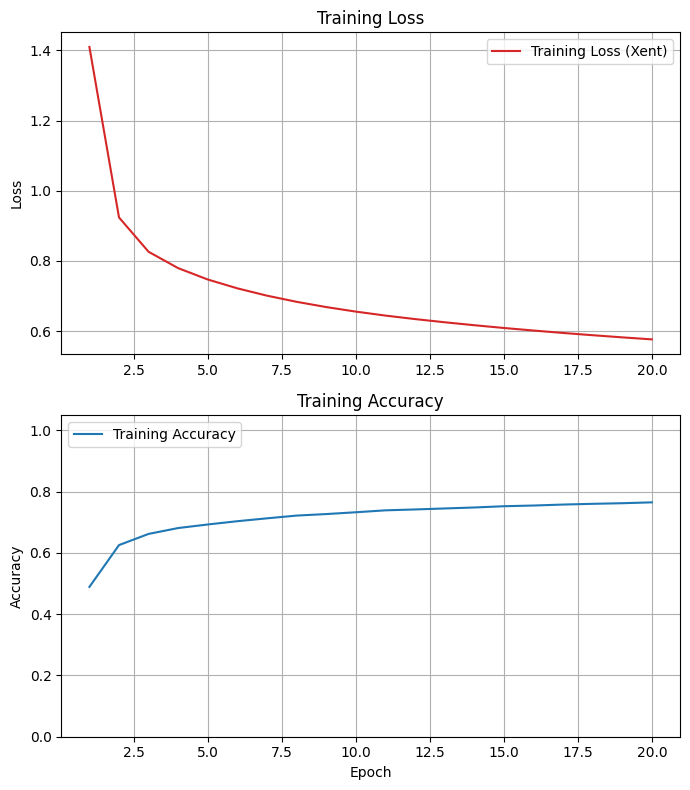

Final Training Loss:     0.5762
Final Training Accuracy: 0.7651
--- Training with Batch Size: 16 ---


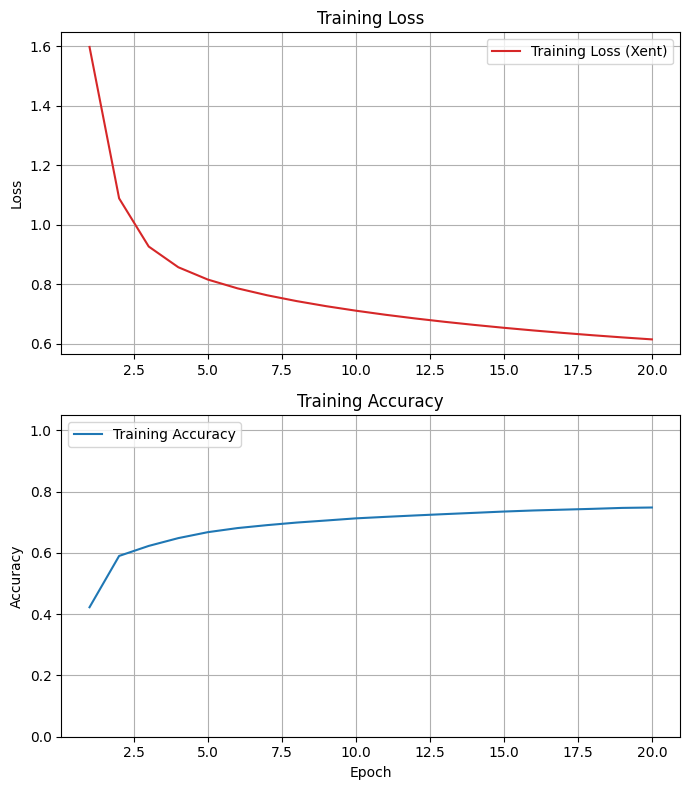

Final Training Loss:     0.6154
Final Training Accuracy: 0.7482
--- Training with Batch Size: 128 ---


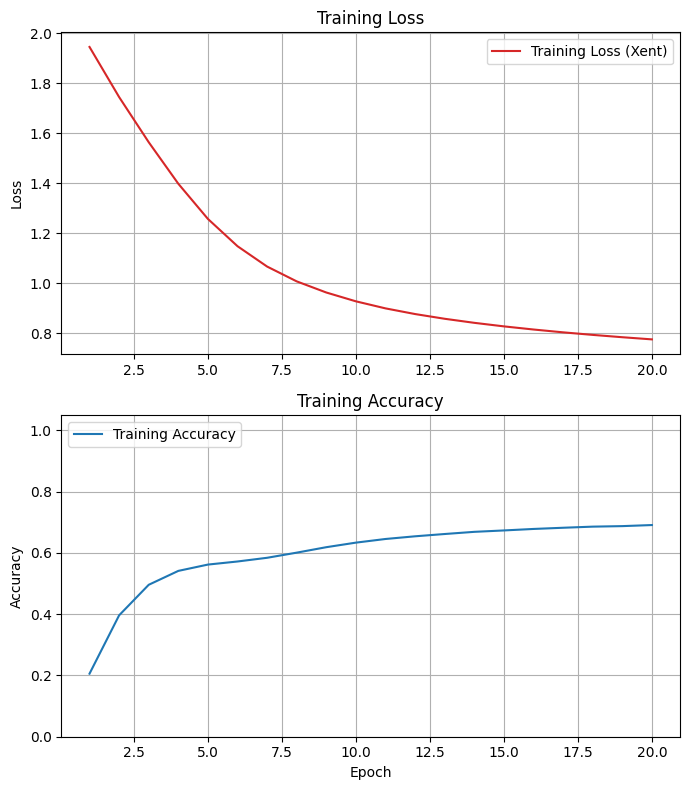

Final Training Loss:     0.7760
Final Training Accuracy: 0.6910


In [8]:
# Your code here

# Define the list of batch sizes to experiment with.
batch_sizes = [4, 8, 16, 128]
best_accuracy_2 = 0
best_batch_size = 0
histories_2 = {}

# Loop through each batch size.
for batch in batch_sizes:
    print(f"--- Training with Batch Size: {batch} ---")

    # Re-build the model to ensure a fresh start for each experiment.
    model_2 = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile the model.
    model_2.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model with the current batch size.
    history = model_2.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=batch,
        verbose=0
    )

    # Store the history for later analysis.
    histories_2[batch] = history.history

    # Plot the results.
    plot_history(history)

    # Check if this batch size produced a better final accuracy.
    final_acc = history.history['accuracy'][-1]
    if final_acc > best_accuracy_2:
        best_accuracy_2 = final_acc
        best_batch_size = batch



In [9]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = best_batch_size             # Replace 0 with your answer

In [10]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [11]:
# Set a2b to the best accuracy score found

a2b = best_accuracy_2             # Replace 0.0 with your answer

In [12]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7782


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.


--- Training with Learning Rate: 0.001 ---


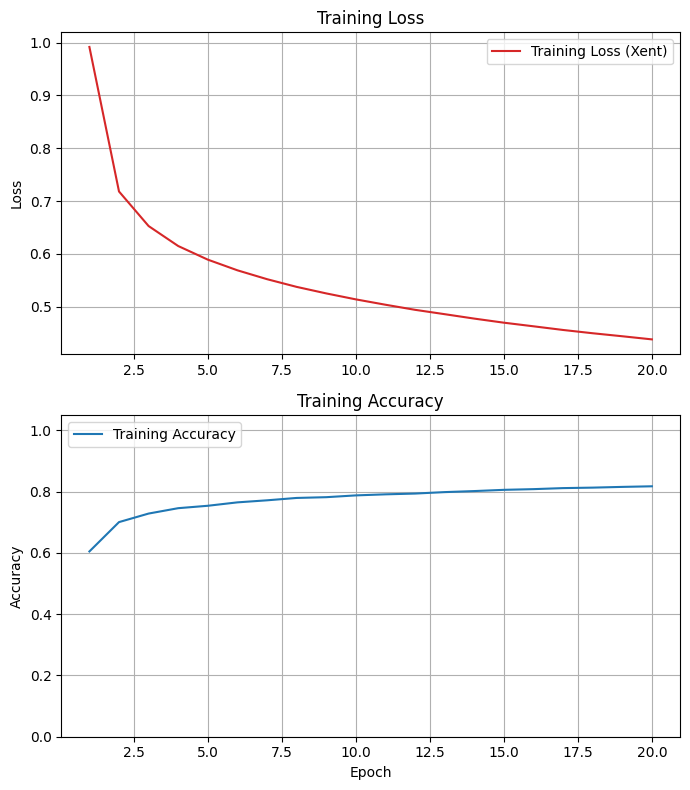

Final Training Loss:     0.4382
Final Training Accuracy: 0.8175
--- Training with Learning Rate: 0.0005 ---


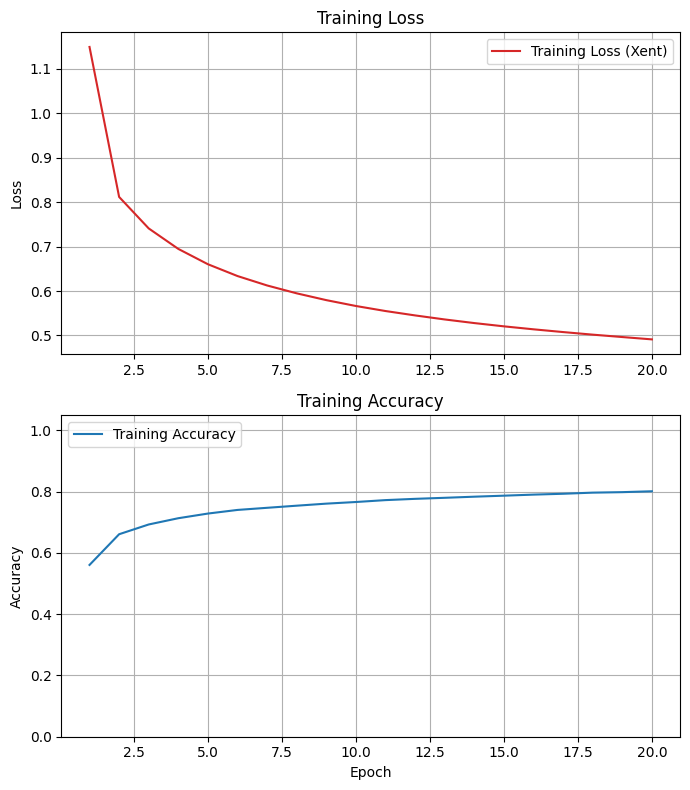

Final Training Loss:     0.4911
Final Training Accuracy: 0.8012
--- Training with Learning Rate: 0.0001 ---


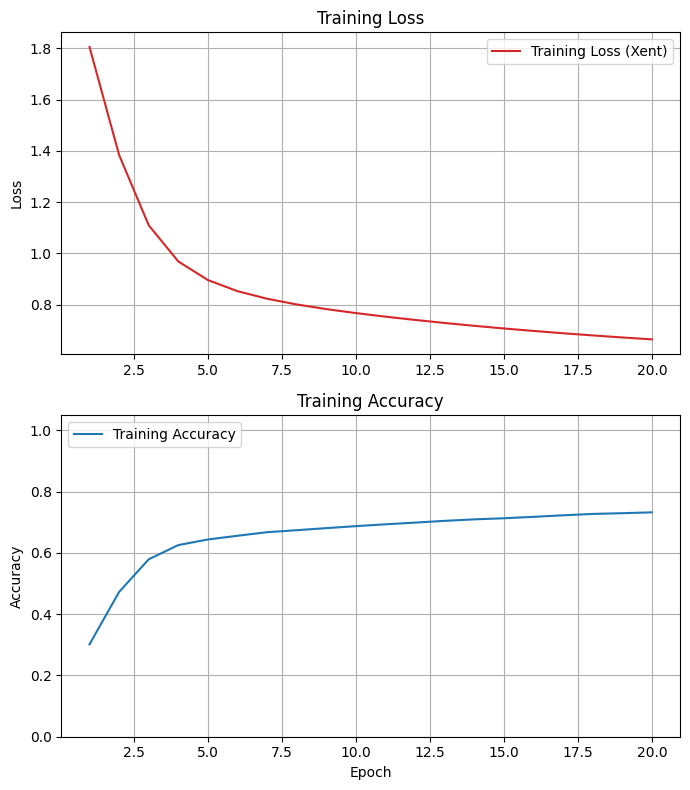

Final Training Loss:     0.6638
Final Training Accuracy: 0.7324
--- Training with Learning Rate: 5e-05 ---


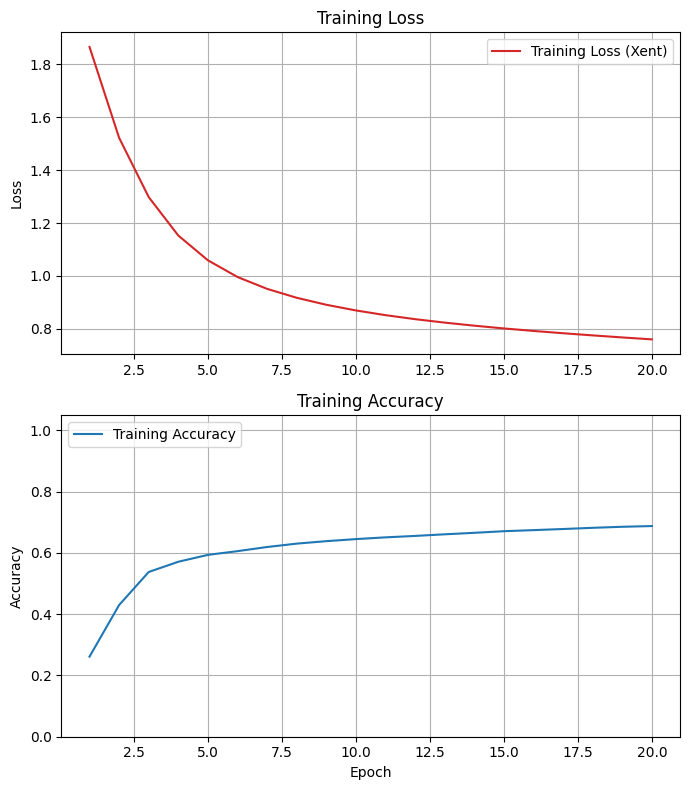

Final Training Loss:     0.7602
Final Training Accuracy: 0.6877
--- Training with Learning Rate: 1e-05 ---


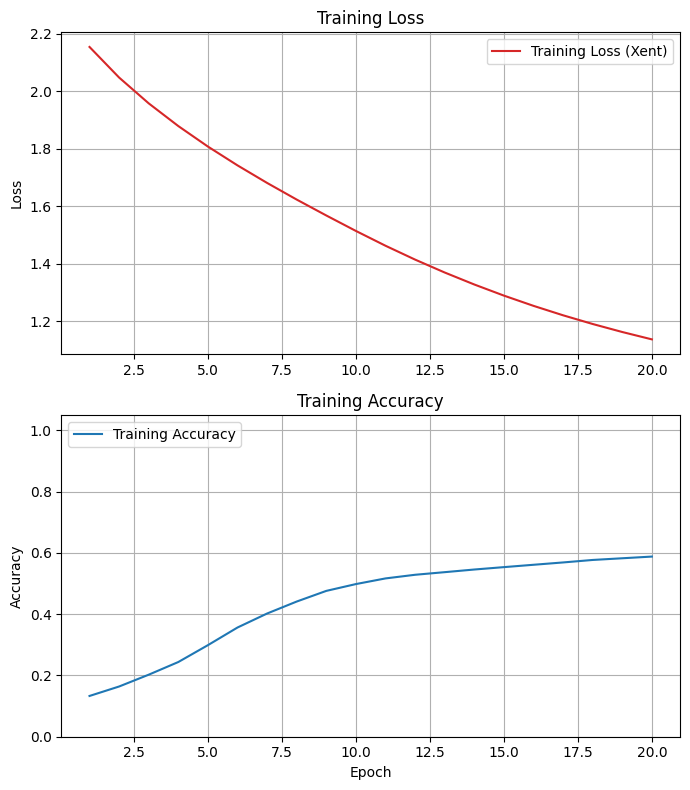

Final Training Loss:     1.1369
Final Training Accuracy: 0.5881


In [13]:
# Your code here

# Define the list of learning rates to experiment with.
learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
best_accuracy_3 = 0
best_lr = 0
histories_3 = {}

# Loop through each learning rate.
for lr in learning_rates:
    print(f"--- Training with Learning Rate: {lr} ---")

    # Re-build the model.
    model_3 = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile the model with the current learning rate.
    model_3.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model with a batch size of 32.
    history = model_3.fit(
        X_train_scaled, y_train,
        epochs=20,
        batch_size=32,
        verbose=0
    )

    # Store and plot the history.
    histories_3[lr] = history.history
    plot_history(history)

    # Check for the best accuracy.
    final_acc = history.history['accuracy'][-1]
    if final_acc > best_accuracy_3:
        best_accuracy_3 = final_acc
        best_lr = lr


In [14]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = best_lr            # Replace 0.0 with your answer

In [15]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [16]:
# Set a3b to the accuracy found by the best learning rate

a3b = best_accuracy_3             # Replace 0.0 with your answer

In [17]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.8175


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.

--- Training with Cosine Decay, Initial LR: 0.01 ---


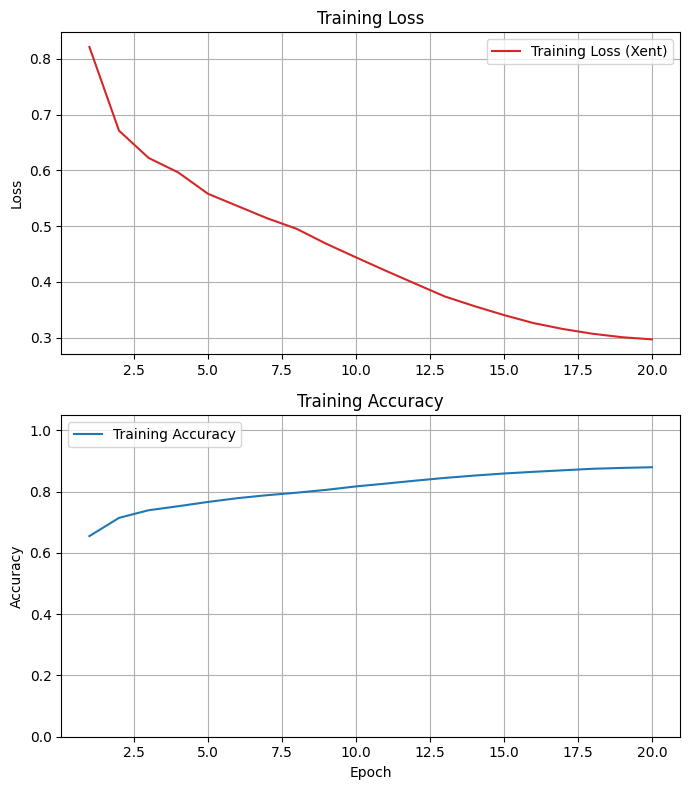

Final Training Loss:     0.2967
Final Training Accuracy: 0.8797
--- Training with Cosine Decay, Initial LR: 0.005 ---


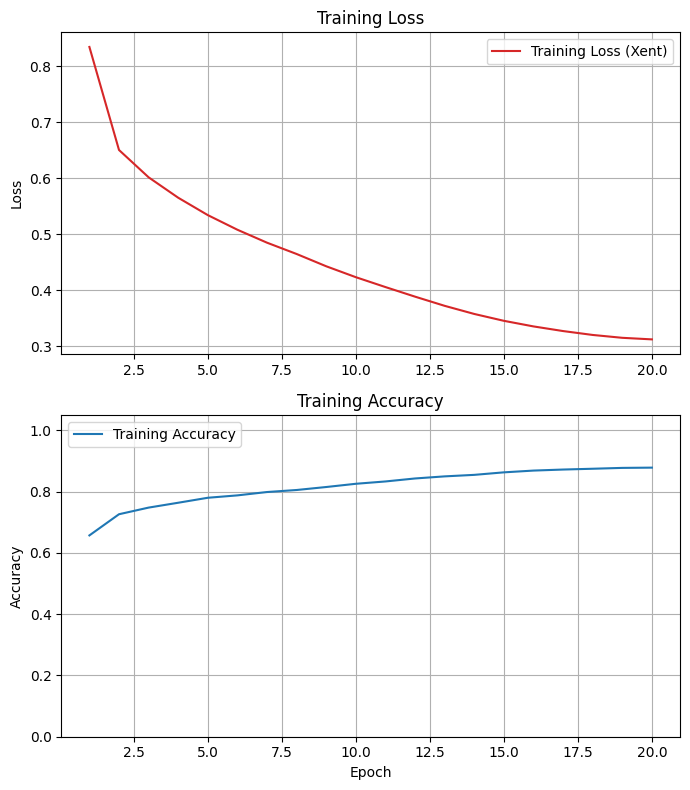

Final Training Loss:     0.3122
Final Training Accuracy: 0.8784
--- Training with Cosine Decay, Initial LR: 0.001 ---


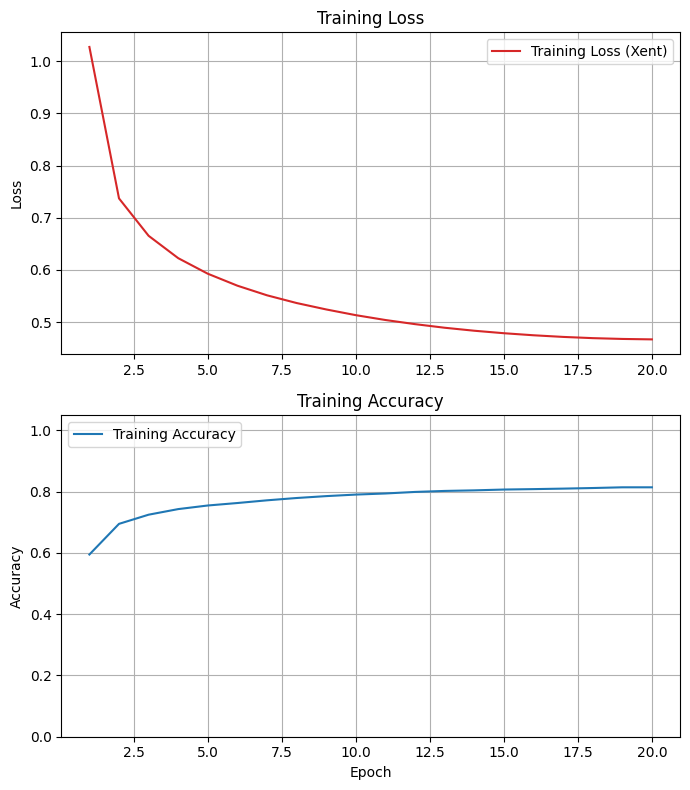

Final Training Loss:     0.4670
Final Training Accuracy: 0.8141
--- Training with Cosine Decay, Initial LR: 0.0005 ---


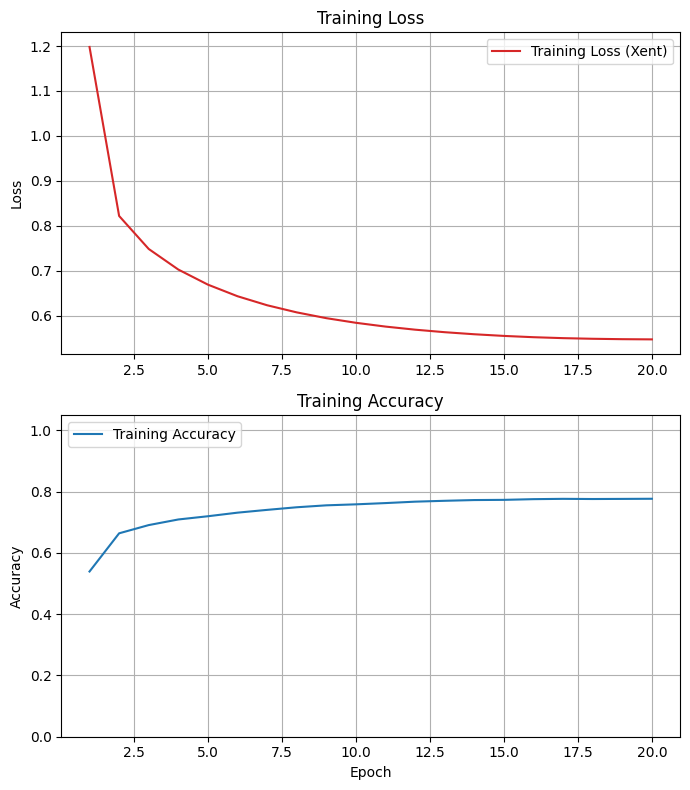

Final Training Loss:     0.5471
Final Training Accuracy: 0.7768
--- Training with Cosine Decay, Initial LR: 0.0001 ---


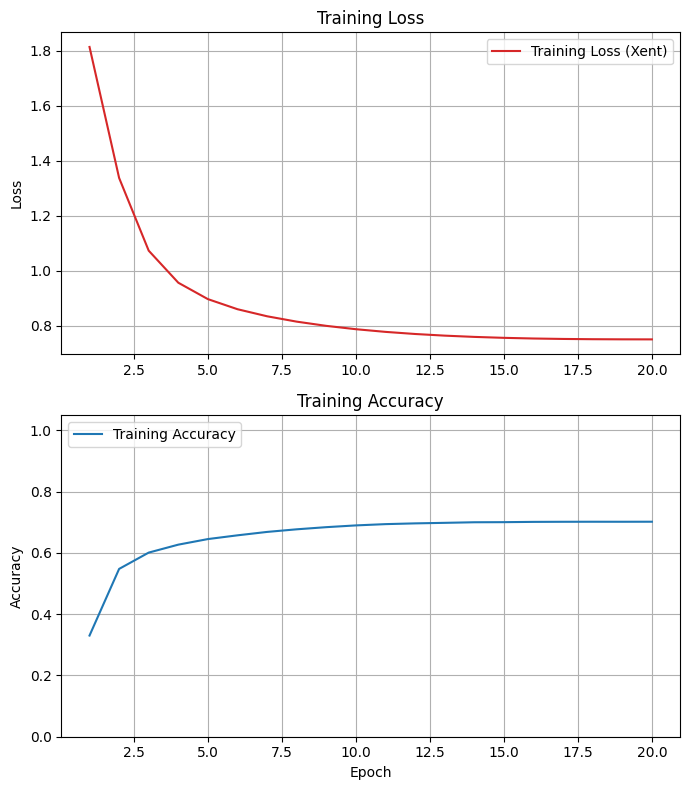

Final Training Loss:     0.7508
Final Training Accuracy: 0.7018


In [18]:
# Your code here

# Define the initial learning rates for the experiments.
initial_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
best_accuracy_4 = 0
best_initial_lr = 0
histories_4 = {}

# Set constants for training.
BATCH_SIZE = 32
EPOCHS = 20

# Calculate decay steps for the CosineDecay scheduler.
# This is the total number of training steps.
decay_steps = (len(X_train_scaled) // BATCH_SIZE) * EPOCHS

# Loop through each initial learning rate.
for initial_lr in initial_learning_rates:
    print(f"--- Training with Cosine Decay, Initial LR: {initial_lr} ---")

    # Define the CosineDecay schedule.
    lr_schedule = CosineDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps,
        alpha=0.0 # The minimum learning rate as a fraction of the initial rate.
    )

    # Re-build the model.
    model_4 = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    # Compile the model using the Adam optimizer with the learning rate schedule.
    model_4.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model.
    history = model_4.fit(
        X_train_scaled, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Store and plot the history.
    histories_4[initial_lr] = history.history
    plot_history(history)

    # Check for the best accuracy.
    final_acc = history.history['accuracy'][-1]
    if final_acc > best_accuracy_4:
        best_accuracy_4 = final_acc
        best_initial_lr = initial_lr


In [19]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = best_initial_lr            # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [21]:
# Set a4b to the best accuracy found

a4b = best_accuracy_4             # Replace 0.0 with your answer

In [22]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8797


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

--- Training the Best Model Configuration ---


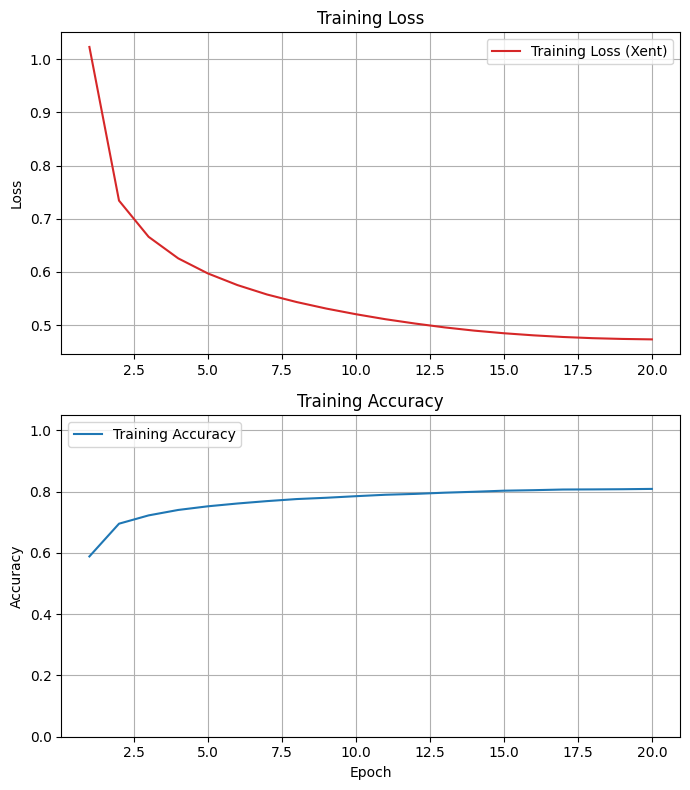

Final Training Loss:     0.4732
Final Training Accuracy: 0.8089

Test Loss:     0.5030
Test Accuracy: 0.7995


In [23]:
# Your code here

# Based on the experiments, the best performance was achieved with
# Cosine Decay and an initial learning rate of 0.001 (from Problem 4),
# using the baseline batch size of 32.

print("--- Training the Best Model Configuration ---")
BEST_BATCH_SIZE = 32
BEST_INITIAL_LR = 0.001
EPOCHS = 20

# Define the learning rate schedule with the best initial learning rate.
final_lr_schedule = CosineDecay(
    initial_learning_rate=BEST_INITIAL_LR,
    decay_steps=(len(X_train_scaled) // BEST_BATCH_SIZE) * EPOCHS,
    alpha=0.0
)

# Build the final model.
final_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

# Compile the final model.
final_model.compile(
    optimizer=Adam(learning_rate=final_lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the final model on the training data.
final_history = final_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BEST_BATCH_SIZE,
    verbose=0
)

# Plot the training history of the best model.
plot_history(final_history)

# Evaluate the final model on the unseen test data.
test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'\nTest Loss:     {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


In [24]:
# Set a5a to the best training accuracy found by your best model

a5a = final_history.history['accuracy'][-1]             # Replace 0.0 with your answer

In [25]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8089


In [26]:
# Set a5b to the test accuracy found by your best model

a5b = test_accuracy            # Replace 0.0 with your answer

In [27]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.7995


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?

2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

### **Reflection Questions (Ungraded)**

1.  **Question**:
    
    * **(a) Training Time**: The **training time will increase** almost proportionally with the data size. Processing more data per epoch requires more batch iterations, leading to longer training times.
    * **(b) Best Batch Size**: With more data, you can typically **use a larger batch size**. Larger batches provide a more accurate estimate of the overall dataset's gradient, making each weight update more stable. They also better utilize the parallel processing power of hardware like GPUs, improving training speed.
    * **(c) Best Learning Rate**: Generally, as the batch size increases, the **optimal learning rate should also increase**. Because larger batches reduce the variance (noise) in the gradient calculation, you can take larger, more confident steps (a higher learning rate) towards the minimum without the risk of diverging.

---
    
2.  **Question**:
    
    * **Why Smaller Batches Generalize Better**: Smaller batches introduce noise into the learning process. Each update is based on a small, potentially unrepresentative sample of the data, causing the optimization path to fluctuate. This noise acts as a form of **regularization**, preventing the model from overfitting by settling into sharp, narrow minima in the loss landscape. Instead, it encourages the model to find wider, flatter minima, which tend to generalize better to new, unseen data. 
    * **If You Must Use a Large Batch**: To counteract the potential for poorer generalization with large batches, you should:
        * **Increase the Learning Rate**: As mentioned above, this helps speed up convergence.
        * **Add Explicit Regularization**: Introduce techniques like **Dropout** or **Weight Decay (L2 regularization)** to prevent overfitting, which the noise from smaller batches would otherwise help with.
        * **Use a Learning Rate Scheduler**: Start with a higher learning rate and gradually decrease it. This allows for rapid initial progress and finer, more stable adjustments as the model gets closer to a solution.

---
    
3.  **Question**:
    
    * **Training Loss/Accuracy**: By doubling the epochs, the model sees the training data more times. Consequently, the **training loss would likely continue to decrease**, and the **training accuracy would continue to increase**, potentially approaching 100%.
    * **Test Accuracy**: The **test accuracy would likely increase to a certain point and then begin to decrease**. This is because after a certain number of epochs, the model starts to overfit—it begins memorizing the noise and specific quirks of the training data instead of learning the underlying general patterns. This hurts its ability to perform well on new, unseen test data.

---
    
4.  **Question**:
    
    * **Not necessarily.** This inverse relationship is only true within an effective range of learning rates. The experiments showed that if the **learning rate is too low** (e.g., `1e-5`), the model barely learns at all. In this case, simply increasing the epochs won't help much because the updates are too small to make meaningful progress. Conversely, if the **learning rate is too high** (e.g., `1e-3`), the training becomes unstable, and the loss can fluctuate wildly or even increase, never converging to a good solution.
    * Therefore, the strategy of "lower learning rate means more epochs" only works when the learning rate is in a "sweet spot"—high enough to make progress but low enough to avoid instability. You cannot fully compensate for a poorly chosen learning rate by just changing the number of epochs.

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


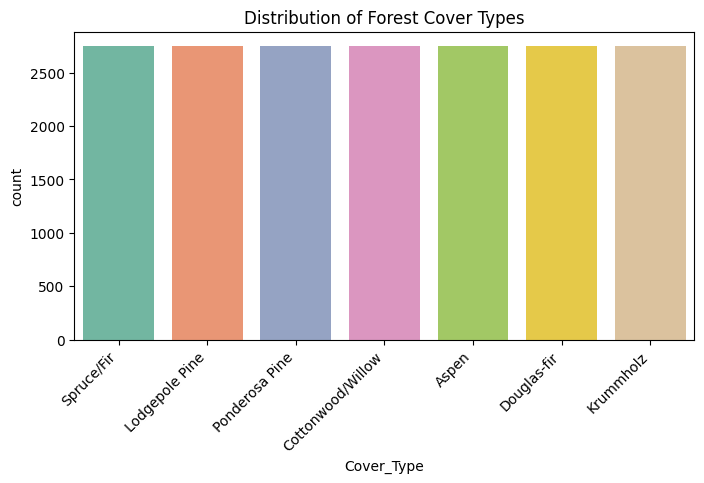

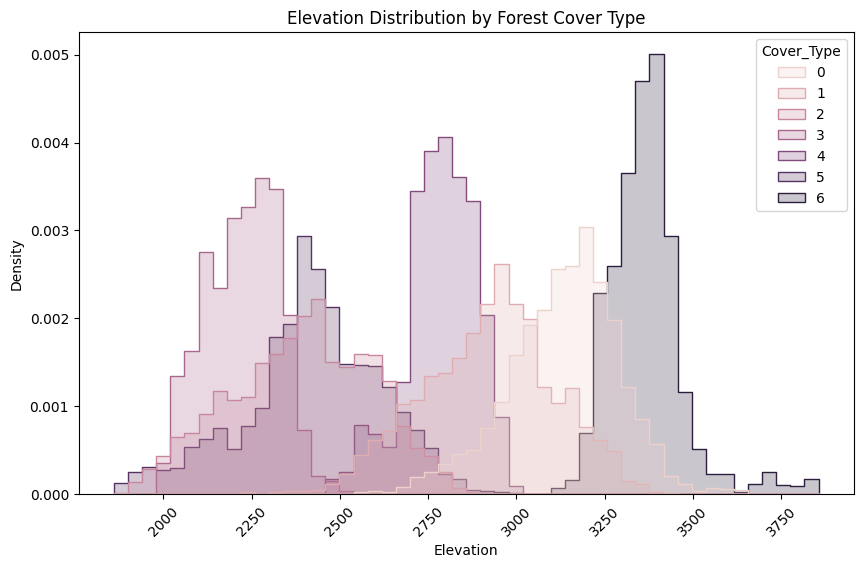

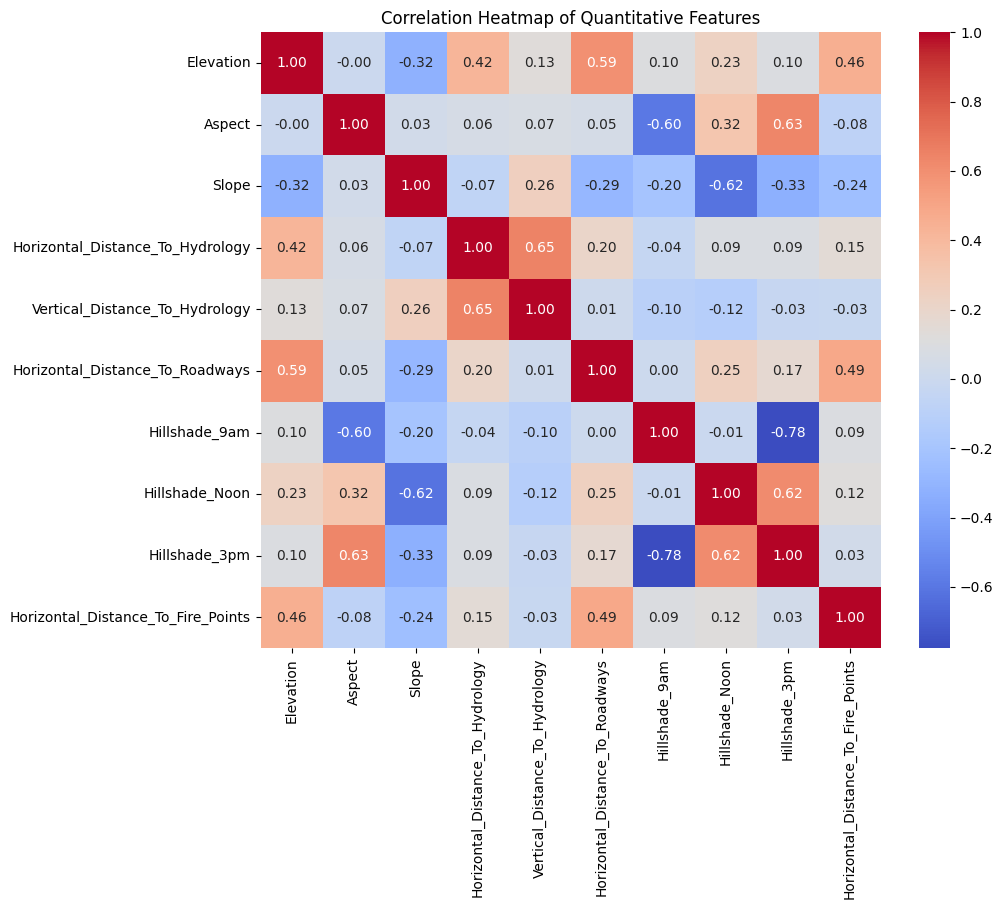

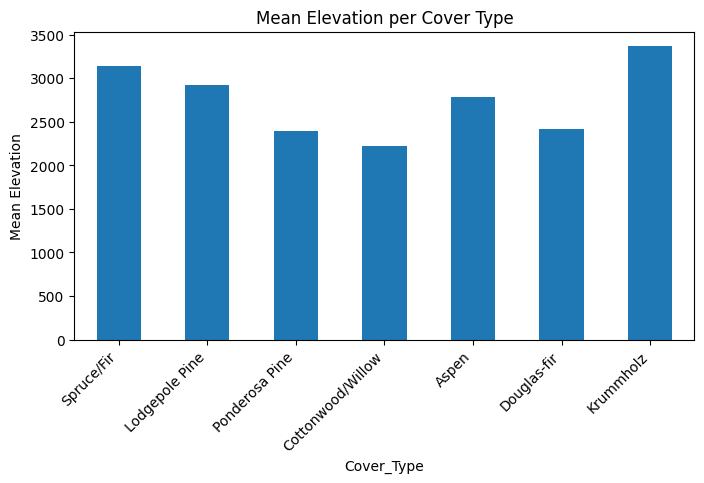

In [28]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
